In [1]:
import sys, os, re, json
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from typing import List, Tuple, Dict
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
!pip install datasets
from datasets import load_dataset
dataset_train=load_dataset("yelp_review_full",split='train')
dataset_test=load_dataset("yelp_review_full",split='test')
# Column names
column_names = ['star', 'review']

# Extract features 
data_train = {'star': dataset_train['label'], 'review': dataset_train['text']}
data_test = {'star': dataset_test['label'], 'review': dataset_test['text']}

# Convert to DataFrame Pandas
data_train = pd.DataFrame(data_train, columns=column_names)
data_test = pd.DataFrame(data_test, columns=column_names)

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

We have a datataset containing two features:
- *text*: the current review
- *label*: the current star reting

In [4]:
print(data_train.head(10))

   star                                             review
0     4  dr. goldberg offers everything i look for in a...
1     1  Unfortunately, the frustration of being Dr. Go...
2     3  Been going to Dr. Goldberg for over 10 years. ...
3     3  Got a letter in the mail last week that said D...
4     0  I don't know what Dr. Goldberg was like before...
5     4  Top notch doctor in a top notch practice. Can'...
6     4  Dr. Eric Goldberg is a fantastic doctor who ha...
7     0  I'm writing this review to give you a heads up...
8     1  Wing sauce is like water. Pretty much a lot of...
9     2  Decent range somewhat close to the city.  The ...


# Data distribution
we should rating distribution here

In [5]:
data_train["star"].value_counts(normalize=False)

star
4    130000
1    130000
3    130000
0    130000
2    130000
Name: count, dtype: int64

In [6]:
def plot_labels(df, title=None):
  ds_labels = df["star"].value_counts(normalize=True)
  ds_labels.sort_index(inplace=True)
  plt.figure(figsize=(4,3))
  ax = ds_labels.plot(kind="bar")
  ax.set_xlabel("Star-" + title)
  ax.set_ylabel("Ratio")
  if title is not None:
    plt.savefig(title + ".eps")
  plt.show()

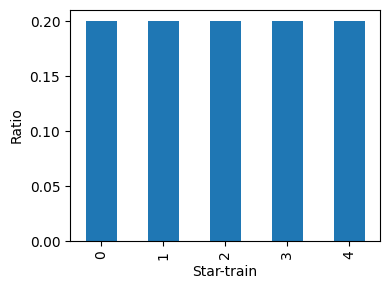

In [7]:
plot_labels(data_train, "train")

We can find that the dataset is balanced.

# Data Preprocessing and split
We need to seperate training, validation, and testing sets.

#### Removing emoticons

We will shortly train a classifier to detect stars rating.
- Before doing so, it is best to remove the emoticons and other symbols to make the classifier more stable.

In [8]:
def clean_sentence(sentence):
    sentence = re.sub(r'\\n',"",sentence)

    #removing emoticons
    sentence = re.sub(r'(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)',"", sentence)

    #removing websites
    sentence = re.sub(r"(http)?s?:?\/\/[A-Za-z0-9^,!.\/'+-=_?]+", "", sentence)

    #numbers
    sentence = re.sub(r"(\d+)(k)", r"\g<1> thousand", sentence)
    sentence = re.sub(r"(\d+)([a-zA-z]+)", r"\g<1> \g<2>", sentence)
    #convert numbers to words
    sentence = re.sub(r"1", " one ", sentence)
    sentence = re.sub(r"2", " two ", sentence)
    sentence = re.sub(r"3", " three ", sentence)
    sentence = re.sub(r"4", " four ", sentence)
    sentence = re.sub(r"5", " five ", sentence)
    sentence = re.sub(r"6", " six ", sentence)
    sentence = re.sub(r"7", " seven ", sentence)
    sentence = re.sub(r"8", " eight ", sentence)
    sentence = re.sub(r"9", " nine ", sentence)
    sentence = re.sub(r"0", " zero ", sentence)

    # removing extraneous symbols
    sentence = re.sub(r"[^A-Za-z0-9^,!.\/'+-=%]", " ", sentence)

    # expanding contraction
    sentence = re.sub(r"\'s", " is ", sentence)
    sentence = re.sub(r"\'ve", " have ", sentence)
    sentence = re.sub(r"n't", " not ", sentence)
    sentence = re.sub(r"i'm", " i am ", sentence)
    sentence = re.sub(r"\'re", " are ", sentence)
    sentence = re.sub(r"\'d", " would ", sentence)
    sentence = re.sub(r"\'ll", " will ", sentence)

    #spacing out symbols
    sentence = re.sub(r",", " ", sentence)
    sentence = re.sub(r"\.", " . ", sentence)
    sentence = re.sub(r"!", " ! ", sentence)
    sentence = re.sub(r"\/", " ", sentence)
    sentence = re.sub(r"\^", " ^ ", sentence)
    sentence = re.sub(r"\+", " + ", sentence)
    sentence = re.sub(r"\-", " - ", sentence)
    sentence = re.sub(r"\=", " = ", sentence)
    sentence = re.sub(r"'", " ", sentence)
    sentence = re.sub(r":", " : ", sentence)
    sentence = re.sub(r"%", " : ", sentence)
    
    #Aggiunta da me, per rimuovere punti nelle frasi, inoltre metto tutto minuscolo per non avere embedding
    #case sensitive
    
    sentence=re.sub('\W', ' ', sentence).lower() 

    return sentence


texts_train_cleaned = list(map(clean_sentence, data_train['review']))
texts_test_cleaned = list(map(clean_sentence, data_test['review']))

In [9]:
print("############# BEFORE CLEANING ###############")
np.random.seed(42)
for i in range(5):
  indexes = np.where(np.array(data_train["star"])==i)[0]  
  print(f"{i} stars: {data_train['review'][np.random.choice(indexes)]}\n")
    
print("\n############# AFTER CLEANING #############")
np.random.seed(42)
for i in range(5):
  indexes = np.where(np.array(data_train["star"])==i)[0]
  print(f"{i} stars: {texts_train_cleaned[np.random.choice(indexes)]}\n")

############# BEFORE CLEANING ###############
0 stars: We just came here with a large group and got kicked out bc we apparently refused to pay our tabs and were over intoxicated.  Umm, I personally paid $123 of overcharged drinks for my friends. We paid whatever charges they said we were refusing and left. We will never go there again. Take your money somewhere else that will at least treat you nicely. The drinks were overpriced and the service was horrible.  Don't waste your time and money.

1 stars: Ordered chicken pad thai and the thai wonton soup. Definitely had better. For the price, was disappointed. Still trying to find a really good Thai place in this city.

2 stars: BF and I went here at 9pm on a Friday night, when they closed at 10, and I have to say everyone was very nice, considering they probably wanted to wrap up and leave. \n\nPlus, my chicken egg roll was amazing. BF's general tso shrimp was very good. \n\nMinus, we each got a very little bowl of rice, and when we packe

In [10]:
X_train, X_val, y_train, y_val = train_test_split(texts_train_cleaned, data_train['star'], test_size=0.2, random_state=42,stratify = data_train['star'])
df_train = pd.DataFrame(data = {'review':X_train,'star':y_train})
df_train.reset_index(drop=True, inplace=True)
df_val = pd.DataFrame(data = {'review':X_val,'star':y_val})
df_val.reset_index(drop=True, inplace=True)
df_test = pd.DataFrame(data = {'review':texts_test_cleaned,'star':data_test['star']})
df_test.reset_index(drop=True, inplace=True)

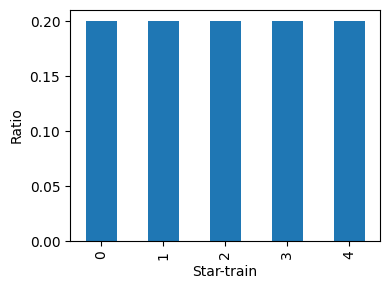

star
1    104000
4    104000
3    104000
2    104000
0    104000
Name: count, dtype: int64

In [11]:
plot_labels(df_train, "train")
df_train["star"].value_counts(normalize=False)

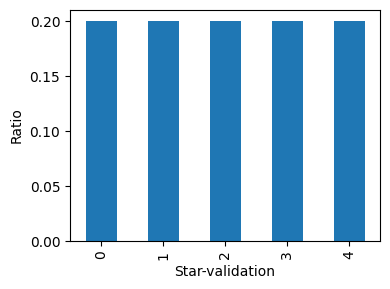

star
0    26000
4    26000
1    26000
3    26000
2    26000
Name: count, dtype: int64

In [12]:
plot_labels(df_val, "validation")
df_val["star"].value_counts(normalize=False)

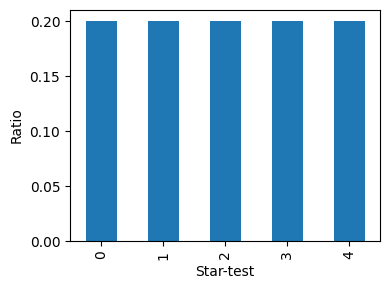

star
0    10000
2    10000
1    10000
3    10000
4    10000
Name: count, dtype: int64

In [13]:
plot_labels(df_test, "test")
df_test["star"].value_counts(normalize=False)

### Tokenization
In this part, we will tokenize reviews and count numbers of tokens for each review. This information will be useful in BERT model. But we will not use these tokens directly for training models.

In [14]:
from nltk.tokenize import word_tokenize

In [15]:
ds_temp = df_train["review"].iloc[:10].map(lambda text: text.split())
print(df_train["review"].iloc[0], '\n', ds_temp.iloc[0])

just went to taste for lunch     well we will get this out of the way firs  the food is good and fresh     everything in there is shiny new and clean and sleek     however  after getting the soup and sandwich combo with a drink  i am still hungry     and i paid over ten bucks     the sandwich is a half in the combo     which means mini  we are talking three bites     those three bites were good  however for   five     nine  nine  today at jersey mikes i would have had a huge sandwich and chips and a drink     so     overall i think they should have toned down the chic   ness and tried to price their food better    
 ['just', 'went', 'to', 'taste', 'for', 'lunch', 'well', 'we', 'will', 'get', 'this', 'out', 'of', 'the', 'way', 'firs', 'the', 'food', 'is', 'good', 'and', 'fresh', 'everything', 'in', 'there', 'is', 'shiny', 'new', 'and', 'clean', 'and', 'sleek', 'however', 'after', 'getting', 'the', 'soup', 'and', 'sandwich', 'combo', 'with', 'a', 'drink', 'i', 'am', 'still', 'hungry', 'a

In [16]:
%time df_train["tokens"] = df_train["review"].map(lambda text: text.split())

CPU times: user 10.3 s, sys: 2.19 s, total: 12.5 s
Wall time: 12.4 s


In [17]:
ds_temp = df_val["review"].iloc[:10].map(lambda text: text.split())
print(df_val["review"].iloc[0], '\n', ds_temp.iloc[0])
df_val["tokens"] = df_val["review"].map(lambda text: text.split())

how does this place even stay in business    it is  disgusting    the food is crap    everything is filthy    all the waitresses look like crackheads    they screwed up a club sandwich   fries    how is that even possible   it deserves negative stars for sucking so badly    
 ['how', 'does', 'this', 'place', 'even', 'stay', 'in', 'business', 'it', 'is', 'disgusting', 'the', 'food', 'is', 'crap', 'everything', 'is', 'filthy', 'all', 'the', 'waitresses', 'look', 'like', 'crackheads', 'they', 'screwed', 'up', 'a', 'club', 'sandwich', 'fries', 'how', 'is', 'that', 'even', 'possible', 'it', 'deserves', 'negative', 'stars', 'for', 'sucking', 'so', 'badly']


In [18]:
ds_temp = df_test["review"].iloc[:10].map(lambda text: text.split())
print(df_test["review"].iloc[0], '\n', ds_temp.iloc[0])
df_test["tokens"] = df_test["review"].map(lambda text: text.split())

i got  new  tires from them and within two weeks got a flat    i took my car to a local mechanic to see if i could get the hole patched  but they said the reason i had a flat was because the previous patch had blown     wait  what  i just got the tire and never needed to have it patched  this was supposed to be a new tire    i took the tire over to flynn is  and they told me that someone punctured my tire  then tried to patch it    so there are resentful tire slashers  i find that very unlikely    after arguing with the guy and telling him that his logic was far fetched he said he would  give me a new tire   this time      i will never go back to flynn is  b c of the way this guy treated me and the simple fact that they gave me a used tire    
 ['i', 'got', 'new', 'tires', 'from', 'them', 'and', 'within', 'two', 'weeks', 'got', 'a', 'flat', 'i', 'took', 'my', 'car', 'to', 'a', 'local', 'mechanic', 'to', 'see', 'if', 'i', 'could', 'get', 'the', 'hole', 'patched', 'but', 'they', 'said', 

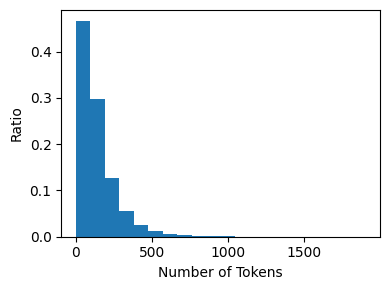

In [19]:
df_train["num_tokens"] = df_train["tokens"].map(len)
ax = df_train["num_tokens"].hist(bins=20, 
                                 figsize=(4,3),
                                 grid = False,
                                 weights=np.ones(df_train.shape[0])/df_train.shape[0])
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.tight_layout()
plt.show()

In [20]:
print(len(df_train[df_train["num_tokens"] <= 128]) / len(df_train["num_tokens"]))
print(len(df_train[df_train["num_tokens"] <= 256]) / len(df_train["num_tokens"]))

0.5986788461538461
0.8641019230769231


In [21]:
df_train.head()

,review,star,tokens,num_tokens
0,just went to taste for lunch well we will ...,1,"[just, went, to, taste, for, lunch, well, we, ...",114
1,excellent service this is the main reason ...,4,"[excellent, service, this, is, the, main, reas...",85
2,found this restaurant on a food network app ...,3,"[found, this, restaurant, on, a, food, network...",35
3,one of the only pizza places i get really exci...,3,"[one, of, the, only, pizza, places, i, get, re...",241
4,frick n chicken is tucked in a strip mall righ...,2,"[frick, n, chicken, is, tucked, in, a, strip, ...",262


In [22]:
from gensim.models.word2vec import Word2Vec

modelsize=70
model = Word2Vec(df_train['tokens'], vector_size=modelsize, min_count=10, window=50,workers=16)
len(model.wv)

43014

In [23]:
from gensim.models import KeyedVectors
model.save('word2vecmodel_rightembedding.kv')

In [24]:
def vectorize(docs, embedding_model=model.wv, useSum=True):
    vectors = np.zeros((len(docs),modelsize))
    for i in range(len(docs)):
    
        tokens = docs[i]
        embeddings = [embedding_model.get_vector(token) for token in tokens if token in embedding_model]
        if (len(embeddings) > 0):
            if (useSum):
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

train_x_vector = vectorize(df_train['tokens'])
train_y=df_train['star']

In [25]:
val_x_vector=vectorize(df_val['tokens'])
y_val=df_val['star']
print(len(val_x_vector))
print(len(y_val))

130000
130000


In [26]:
test_x_vector=vectorize(df_test['tokens'])
test_y=df_test['star']
print(len(test_x_vector))
print(len(test_y))

50000
50000


### Vectorization
We will try following settings for vectorization:
- Word representation: CountVectorizer vs. TfidfVectorizer
- N-grams: unigram & bigram
- Minimum document frequency: 5
- Convert to lowercase
- Use stop words

# Experiments and Results
We will use machine learning models and transformer-based models
### Machine Learning
Navie Bayes, Logistic Regression, Random Forest, and SGD Classifier will used in this section.

#### Evaluation Metrics
- Precision, recall, F1 score
- Accuracy
- Confusion matrix

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [28]:
import seaborn as sns
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
  if y_pred is None:
    y_pred = model.predict(X)

  print(label + ' Set')
  print("Accuracy:", accuracy_score(y, y_pred))
  print()

  print(classification_report(y, y_pred, digits=4))
  disp = confusion_matrix(y, y_pred, 
                          normalize='true')
  sns.heatmap(disp, annot=True, fmt=".2f", cmap="Blues")
  plt.savefig(model_name + "_" + label.lower() + ".eps")
  plt.show()
  print()

In [29]:
def evaluate_model(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
  evaluate_model_Xy(model, train_x_vector, train_y, label="Training", model_name=model_name)
  evaluate_model_Xy(model, val_x_vector, y_val, label="Validation", model_name=model_name)
  evaluate_model_Xy(model, test_x_vector, test_y, label="Testing", model_name=model_name)

### Logistic Regression Classifier-Lasso

In [30]:
from sklearn.linear_model import LogisticRegression
clf_lr_lasso = LogisticRegression(
                                  tol=1e-4,
                                  fit_intercept=True,
                                  class_weight='balanced',
                                  random_state=0,
                                  solver='lbfgs',
                                  max_iter=500,
                                  multi_class='auto',
                                  verbose=1,
                                  n_jobs=-1)

In [31]:
clf_lr_lasso.fit(train_x_vector, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          355     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36908D+05    |proj g|=  1.28187D+07


 This problem is unconstrained.



At iterate   50    f=  5.51977D+05    |proj g|=  3.50525D+05

At iterate  100    f=  5.51140D+05    |proj g|=  4.70614D+04

At iterate  150    f=  5.50641D+05    |proj g|=  3.98874D+04

At iterate  200    f=  5.50543D+05    |proj g|=  1.15812D+04

At iterate  250    f=  5.50534D+05    |proj g|=  9.11737D+03

At iterate  300    f=  5.50531D+05    |proj g|=  4.65804D+03

At iterate  350    f=  5.50527D+05    |proj g|=  7.09142D+03

At iterate  400    f=  5.50519D+05    |proj g|=  7.71221D+03

At iterate  450    f=  5.50455D+05    |proj g|=  3.83637D+04

At iterate  500    f=  5.50398D+05    |proj g|=  1.11693D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1,
                   random_state=0, verbose=1)

Training Set
Accuracy: 0.5606403846153846

              precision    recall  f1-score   support

           0     0.6755    0.7530    0.7121    104000
           1     0.5048    0.4493    0.4755    104000
           2     0.4735    0.4475    0.4601    104000
           3     0.4825    0.4226    0.4506    104000
           4     0.6223    0.7308    0.6722    104000

    accuracy                         0.5606    520000
   macro avg     0.5517    0.5606    0.5541    520000
weighted avg     0.5517    0.5606    0.5541    520000



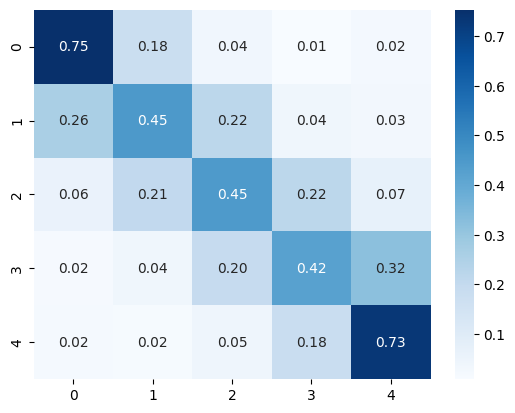


Validation Set
Accuracy: 0.5606461538461538

              precision    recall  f1-score   support

           0     0.6760    0.7580    0.7147     26000
           1     0.5032    0.4456    0.4726     26000
           2     0.4714    0.4506    0.4608     26000
           3     0.4823    0.4195    0.4487     26000
           4     0.6249    0.7295    0.6731     26000

    accuracy                         0.5606    130000
   macro avg     0.5516    0.5606    0.5540    130000
weighted avg     0.5516    0.5606    0.5540    130000



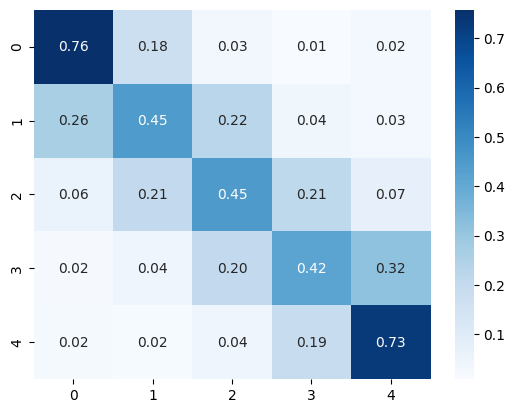


Testing Set
Accuracy: 0.56146

              precision    recall  f1-score   support

           0     0.6698    0.7502    0.7077     10000
           1     0.5029    0.4489    0.4744     10000
           2     0.4774    0.4488    0.4627     10000
           3     0.4865    0.4337    0.4586     10000
           4     0.6279    0.7257    0.6733     10000

    accuracy                         0.5615     50000
   macro avg     0.5529    0.5615    0.5553     50000
weighted avg     0.5529    0.5615    0.5553     50000



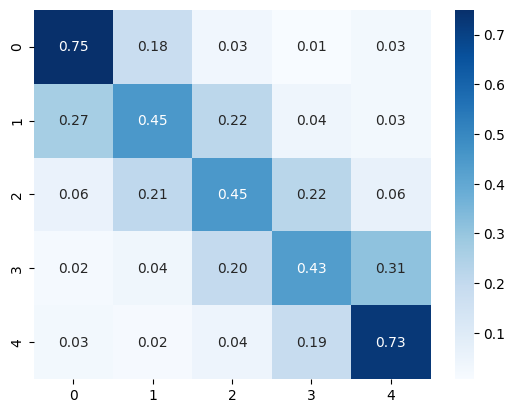

In [32]:
evaluate_model(clf_lr_lasso, model_name="lr_tfidf_lasso")